# CommonRoad CLCS - Additional Features

In this tutorial we show some additional features of our packages, which can be useful for developing and debugging when using curvilinear coordinate systems for different applications (e.g., for motion planning, predicition etc...).

### Create CLCS for an example scenario

Load scenario

In [1]:
import os
from commonroad.common.file_reader import CommonRoadFileReader

# Load scenario
scenario_name = 'ZAM_Tjunction-1_42_T-1.xml'
file_path = os.path.join(os.getcwd(), "../", scenario_name)
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

Plan initial reference path

In [2]:
from commonroad_route_planner.route_planner import RoutePlanner
from commonroad_route_planner.reference_path_planner import ReferencePathPlanner

# Plan initial reference path
routes = RoutePlanner(scenario.lanelet_network, planning_problem).plan_routes()
ref_path = ReferencePathPlanner(
    lanelet_network=scenario.lanelet_network,
    planning_problem=planning_problem,
    routes=routes
).plan_shortest_reference_path().reference_path

Running cmake --build & --install in /home/gerald/Documents/CommonRoad/cps/commonroad-clcs/build/Release_cp311-cp311-manylinux_2_31_x86_64


Initialize parameter object

In [3]:
from commonroad_clcs.config import (
    CLCSParams,
    ProcessingOption,
    ResamplingOption
)

# initialize CLCS params
params = CLCSParams()

Pre-process reference path. As an example we smooth the path using curve subdivision and resample it adaptively

In [4]:
from commonroad_clcs.ref_path_processing.factory import ProcessorFactory

# set pre-processing options and call processor
params.processing_option = ProcessingOption.CURVE_SUBDIVISION
params.subdivision.max_curvature = 0.125
params.resampling.option = ResamplingOption.ADAPTIVE
ref_path_processor = ProcessorFactory.create_processor(params)
ref_path = ref_path_processor(ref_path)

When creating the CLCS, we can set the logging level for the C++ backend which can be helpful for debugging ("off" by default).

In [5]:
from commonroad_clcs.clcs import CurvilinearCoordinateSystem

# log level
params.logging_level = "info"  # "debug"
# proj domain computation method for visualization below
params.method = 2
curvilinear_cosy = CurvilinearCoordinateSystem(
    reference_path=ref_path,
    params=params,
    preprocess_path=False
)

[info] [CLCS_Logger] Initialization of CLCS done


### Visualize unique projection domain

The projection domain is the area in which points can be transformed from the Cartesian to the curvilinear frame (and vice-versa) uniquely. Depending on the shape (i.e., the curvature profile) of the reference path, there may be areas where points can not be transformed uniquely, which can lead to problems for downstream tasks (e.g., trajectory generation, collision checking...)

For debugging purposes, it can be helpful to visualize an approximation of the projection domain (shown in orange): 

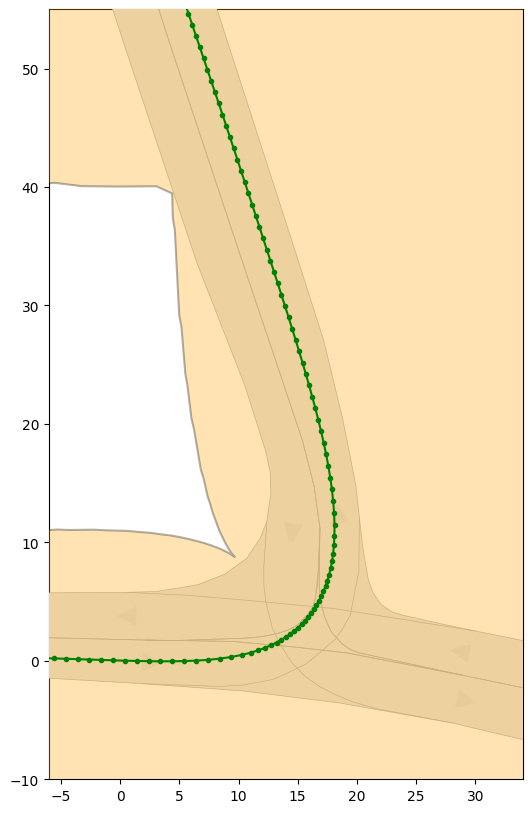

In [6]:
from commonroad.visualization.mp_renderer import MPRenderer
from commonroad_clcs.helper.visualization import plot_scenario_and_clcs

rnd = MPRenderer(figsize=(7, 10), plot_limits=[-6, 34.0, -10, 55])
plot_scenario_and_clcs(
    scenario,
    curvilinear_cosy,
    renderer=rnd,
    proj_domain_plot="full"
)

### Plot reference path states

It can also be helpful to investigate the properties of the reference path (orientation, curvature and curvature rate) to check whether the path is sufficiently smooth or contains jerky parts.

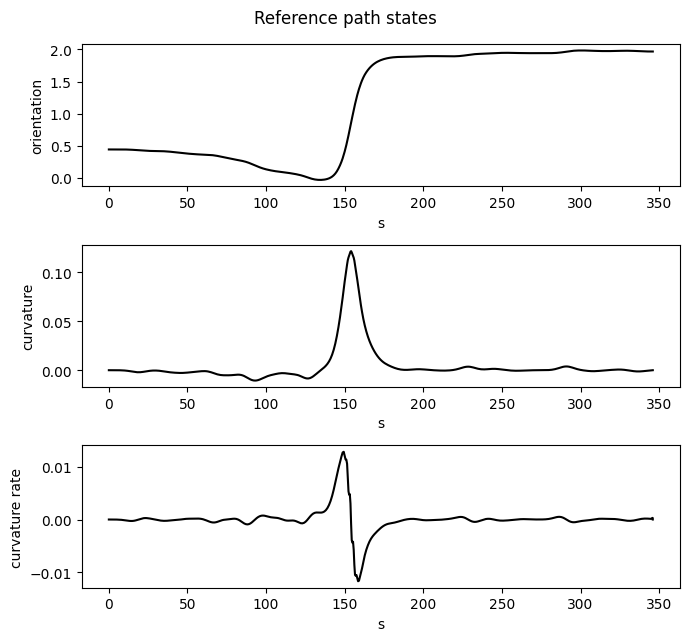

In [7]:
curvilinear_cosy.plot_reference_states()